In [ ]:
import datetime as dt
from pathlib import Path
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
plt.close('all')
import yfinance as yf
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
xrp_1hr = yf.download(tickers='XRP-USD', start='2019-09-01', end = '2021-08-11', interval='1h')
xrp_1hr.drop(columns = ['Open','High','Low','Adj Close','Volume'], inplace = True)
xrp_1hr.reset_index(inplace=True)
xrp_1hr.rename(columns = {'index':'Datetime'}, inplace = True)
xrp_1hr.set_index(pd.to_datetime(xrp_1hr['Datetime'],infer_datetime_format=True),inplace=True)
xrp_1hr.head()

[*********************100%***********************]  1 of 1 completed


,Datetime,Close
Datetime,,
2019-09-01 01:00:00+01:00,2019-09-01 01:00:00+01:00,0.2591
2019-09-01 02:00:00+01:00,2019-09-01 02:00:00+01:00,0.2584
2019-09-01 03:00:00+01:00,2019-09-01 03:00:00+01:00,0.2578
2019-09-01 04:00:00+01:00,2019-09-01 04:00:00+01:00,0.2585
2019-09-01 05:00:00+01:00,2019-09-01 05:00:00+01:00,0.2581


In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
plt.close("all")

In [ ]:
xrp_diff = xrp_1hr['Close'].diff()
xrp_diff

Datetime
2019-09-01 01:00:00+01:00         NaN
2019-09-01 02:00:00+01:00   -0.000700
2019-09-01 03:00:00+01:00   -0.000600
2019-09-01 04:00:00+01:00    0.000700
2019-09-01 05:00:00+01:00   -0.000400
                               ...   
2021-08-10 20:00:00+01:00    0.008558
2021-08-10 21:00:00+01:00    0.008943
2021-08-10 22:00:00+01:00    0.015082
2021-08-10 23:00:00+01:00   -0.006482
2021-08-11 00:00:00+01:00   -0.001047
Name: Close, Length: 16989, dtype: float64

In [ ]:
up = xrp_diff.clip(lower=0)
down = -1*xrp_diff.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
rs

Datetime
2019-09-01 01:00:00+01:00         NaN
2019-09-01 02:00:00+01:00    0.000000
2019-09-01 03:00:00+01:00    0.000000
2019-09-01 04:00:00+01:00    0.077716
2019-09-01 05:00:00+01:00    0.074169
                               ...   
2021-08-10 20:00:00+01:00    1.393988
2021-08-10 21:00:00+01:00    1.615552
2021-08-10 22:00:00+01:00    2.017935
2021-08-10 23:00:00+01:00    1.701120
2021-08-11 00:00:00+01:00    1.655912
Name: Close, Length: 16989, dtype: float64

In [ ]:
xrp_1hr['RSI'] = 100 - (100/(1 + rs))
xrp_1hr['RSI']

Datetime
2019-09-01 01:00:00+01:00          NaN
2019-09-01 02:00:00+01:00     0.000000
2019-09-01 03:00:00+01:00     0.000000
2019-09-01 04:00:00+01:00     7.211196
2019-09-01 05:00:00+01:00     6.904779
                               ...    
2021-08-10 20:00:00+01:00    58.228698
2021-08-10 21:00:00+01:00    61.767147
2021-08-10 22:00:00+01:00    66.864756
2021-08-10 23:00:00+01:00    62.978326
2021-08-11 00:00:00+01:00    62.348157
Name: RSI, Length: 16989, dtype: float64

In [ ]:
xrp_1hr_rsi=xrp_1hr.iloc[: , 1:]
print(xrp_1hr_rsi)

                              Close        RSI
Datetime                                      
2019-09-01 01:00:00+01:00  0.259100        NaN
2019-09-01 02:00:00+01:00  0.258400   0.000000
2019-09-01 03:00:00+01:00  0.257800   0.000000
2019-09-01 04:00:00+01:00  0.258500   7.211196
2019-09-01 05:00:00+01:00  0.258100   6.904779
...                             ...        ...
2021-08-10 20:00:00+01:00  0.834750  58.228698
2021-08-10 21:00:00+01:00  0.843693  61.767147
2021-08-10 22:00:00+01:00  0.858775  66.864756
2021-08-10 23:00:00+01:00  0.852293  62.978326
2021-08-11 00:00:00+01:00  0.851247  62.348157

[16989 rows x 2 columns]


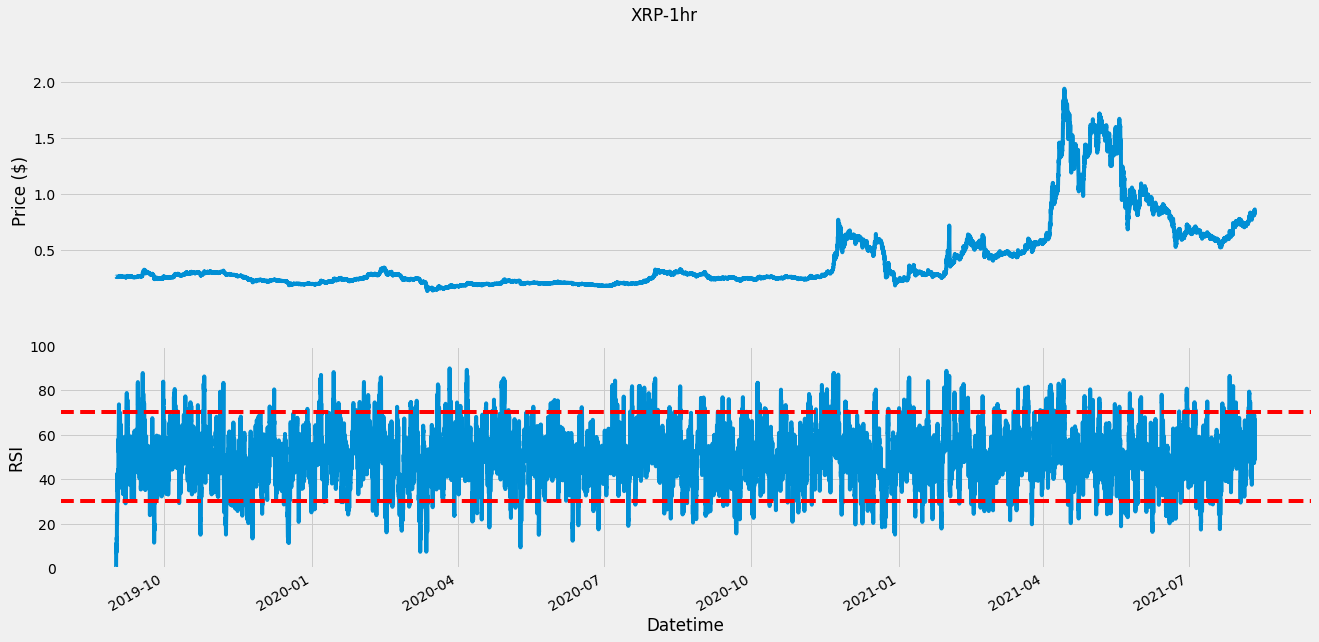

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)
fig.suptitle('XRP-1hr')
xrp_1hr_rsi['Close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')
xrp_1hr_rsi['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color='r', linestyle='--')
ax2.axhline(70, color='r', linestyle='--')
ax2.set_ylabel('RSI')

plt.show()

In [ ]:
# TRADE STRATEGY BASED ON RSI
def implement_rsi_strategy(prices, rsi):
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if rsi[i] >= 70 :
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i] <= 30:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

buy_price, sell_price, rsi_signal = implement_rsi_strategy(xrp_1hr_rsi['Close'], xrp_1hr_rsi['RSI'])

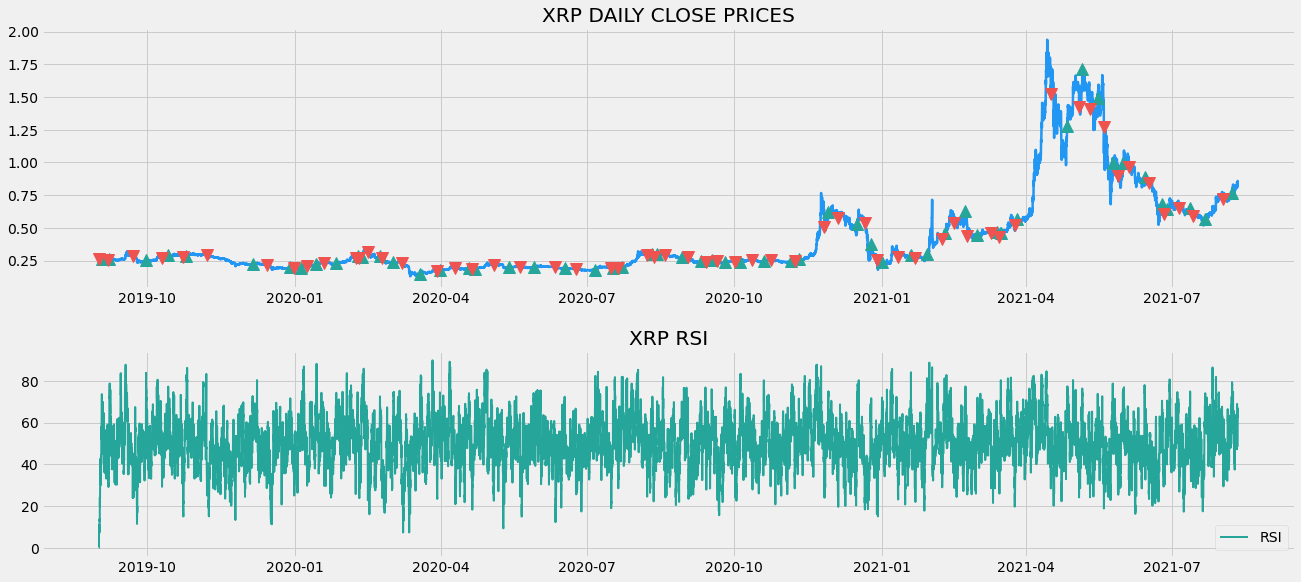

In [ ]:
# PLOTTING TRADE SIGNALS FOR SQ AROON 25 STRATEGY
df = xrp_1hr_rsi
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(df['Close'], linewidth = 2.5, color = '#2196f3')
ax1.plot(df.index, buy_price, marker = '^', color = '#26a69a', markersize = 12)
ax1.plot(df.index, sell_price, marker = 'v', color = '#ef5350', markersize = 12)
ax1.set_title('XRP DAILY CLOSE PRICES')
ax2.plot(df['RSI'], color = '#26a69a', linewidth = 2, label = 'RSI')
ax2.legend()
ax2.set_title('XRP RSI')
plt.show()

In [ ]:
# CREATING POSITION FOR SQ BASED ON AROON 25 SIGNALS
position = []

for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = df['RSI']
close_price = df['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(df.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,RSI,rsi_signal,rsi_position
Datetime,,,,
2019-09-01 01:00:00+01:00,0.259100,NaN,0,1
2019-09-01 02:00:00+01:00,0.258400,0.000000,-1,0
2019-09-01 03:00:00+01:00,0.257800,0.000000,0,0
2019-09-01 04:00:00+01:00,0.258500,7.211196,0,0
2019-09-01 05:00:00+01:00,0.258100,6.904779,0,0
...,...,...,...,...
2021-08-10 20:00:00+01:00,0.834750,58.228698,0,1
2021-08-10 21:00:00+01:00,0.843693,61.767147,0,1
2021-08-10 22:00:00+01:00,0.858775,66.864756,0,1


In [ ]:
# BACKTESTING THE SQ AROON TRADE STRATEGY
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in XRP : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in XRP : 97228.58
Profit percentage of the RSI strategy : 97%


In [ ]:
strategy.to_csv('XRP_RSI_TRADE_STRATEGY')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>